In [1]:
from ipywidgets import *
from IPython.display import display, clear_output
import os
import json
import folium
import pandas as pd
import numpy as np
import boto3
import branca.colormap as cm
import numpy as np
import config as cfg

import vis_functions
import transit_vis

In [2]:
#creates function which dictates outputs based off textbox intput and button "clicks"
def generate_folium_map_widget(segment_file, census_file, colormap):
    """Draws together speed/socioeconomic data to create a Folium map.

    Loads segments with speed data, combined census data, and the colormap
    generated from the list of speeds to be plotted. Plots all data sources on
    a new Folium Map object centered on Seattle, and returns the map.

    Args:
        segment_file: A string path to the geojson file generated by
            write_speeds_to_map_segments that should contain geometry as well
            as speed data.
        census_file: A string path to the geojson file generated by
            write_census_data_to_csv that should contain the combined s0801 and
            s1902 tables.
        colormap: A Colormap object that describes what speeds should be mapped
            to what colors.

    Returns:
        A Folium Map object containing the most up-to-date speed data from the
        dynamodb.
    """
    # Read in route shapefile and give it the style function above
    kcm_routes = folium.GeoJson(
        f"{segment_file}_w_speeds_tmp.geojson",
        style_function=lambda feature: {
            'color': colormap(feature['properties']['AVG_SPEED_M_S']),
            'weight': 2})


    # Read in the census data/shapefile and create a choropleth based on income
    seattle_tracts_df = pd.read_csv(f"{census_file}_tmp.csv")
    seattle_tracts_df['GEO_ID'] = seattle_tracts_df['GEO_ID'].astype(str)
    seattle_tracts_df['mean_income'] = pd.to_numeric(\
                                         seattle_tracts_df['mean_income'],\
                                         errors='coerce')

    # mde the number smaller so the legend would look better
    seattle_tracts_df['mean_income'] = seattle_tracts_df['mean_income']/1000

    seattle_tracts_df = seattle_tracts_df.dropna()    

    seattle_tracts = folium.Choropleth(
        geo_data=f"{census_file}.geojson",
        name='Socioeconomic Data',
        data=seattle_tracts_df,
        columns=['GEO_ID', 'mean_income'], 
        # added thresholding values for coloring based off widget inputs
        threshold_scale=[seattle_tracts_df["mean_income"].min()-1, \
                         int(min_income_input_box.value)/1000, \
                         int(max_income_input_box.value)/1000, \
                         seattle_tracts_df["mean_income"].max()+1],
        key_on='feature.properties.GEOID10',
        fill_color="PuBuGn",
        #fill_color='PuBu',
        fill_opacity=0.7,
        line_opacity=0.4,
        legend_name='mean income (1000s)')

    #Create folium marker based off destination
    dest_lat = float(destination_loc.value.split(",")[0])
    dest_long = float(destination_loc.value.split(" ")[1])            
    dest_marker = folium.Marker(
        location=[dest_lat, dest_long], 
        popup="Destination", 
        icon=folium.Icon(color="green", icon="info-sign"))

    # Draw map using the speeds and census data
    f_map = folium.Map(
        location=[47.606209, -122.332069],
        zoom_start=11,
        prefer_canvas=True)
    seattle_tracts.add_to(f_map)
    kcm_routes.add_to(f_map)
    dest_marker.add_to(f_map)
    colormap.caption = 'Average Speed (m/s)'
    colormap.add_to(f_map)
    folium.LayerControl().add_to(f_map)
    return f_map

def btn_execute_app(obj): 
    with output:
        clear_output()
        
        if len(destination_loc.value) < 1:
            raise ValueError("Please enter a value for your destination.")
        else:
            pass
        
        if len(commute_time.value) < 1:
            raise ValueError("Please enter a value for your desired commute time.")
        else:
            pass
        
        if len(min_income_input_box.value) < 1:
            raise ValueError("Please enter a value for your minimum yearly income.")
        else:
            pass
        
        if len(max_income_input_box.value) < 1:
            raise ValueError("Please enter a value for your maximum yearly income.")
        else:
            pass
        
        if commute_time.value.isdecimal() == False:
            raise ValueError("Your commute time input is not valid, please enter a whole number.")
        else:
            pass
        
        if min_income_input_box.value.isdecimal() == False:
            raise ValueError("Your minimum income value input is not valid, please enter a whole number.")
        else:
            pass
        
        if max_income_input_box.value.isdecimal() == False:
            raise ValueError("Your maximum income value input is not valid, please enter a whole number.")
        else:
            pass             
        
        table_name='KCM_Bus_Routes'
        s0801_path='../data/s0801'
        s1902_path='../data/s1902'
        segment_path='../data/kcm_routes'
        census_path='../data/seattle_census_tracts_2010'
        
        print("Modifying and writing census data...")
        vis_functions.write_census_data_to_csv(s0801_path, s1902_path, census_path)

        # Connect to dynamodb
        print("Connecting to dynamodb...")
        table = transit_vis.connect_to_dynamo_table(table_name)

        # Query the dynamoDB for all speed data
        print("Getting speed data from dynamodb...")
        speed_lookup = transit_vis.table_to_lookup(table)

        print("Writing speed data to segments for visualization...")
        speeds = vis_functions.write_speeds_to_map_segments(
        speed_lookup,
        segment_path)

        # Create the color mapping for speeds
        print("Generating map...")
        linear_cm = cm.LinearColormap(
            ['red', 'yellow', 'green'],
            vmin=0.0,
            vmax=np.ceil(np.percentile(speeds[speeds > 0.0], 95)))
    
        f_map = generate_folium_map_widget(segment_path, census_path, linear_cm)
        print("Saving map...")
        vis_functions.save_and_view_map(f_map, 'output_map_widgets.html')



Output()

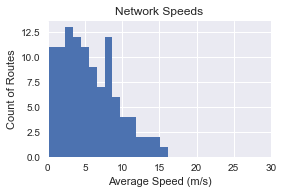

In [3]:
#creates destination input box
destination_loc = widgets.Text( 
    value="47.606209, -122.332069",
    placeholder='Enter Destination Location in "lat, long"',
    description='Destination: ',
    disabled=False,
    style = {'description_width': 'initial'},
    layout=Layout(width="380px", height="auto") 
)

#creates commute time input box
commute_time = widgets.Text(
    placeholder='Enter maximum desired commute time (mins)',
    description='Commute Time: ',
    disabled=False,
    style = {'description_width': 'initial'},
    layout=Layout(width="380px", height="auto")
)

# creates minimum desired rent input box
min_income_input_box = widgets.Text(
    placeholder='Enter minimum yearly income ($)',
    description='Income Minimum:',
    disabled=False,
    style = {'description_width': 'initial'},
    layout=Layout(width="380px", height="auto")
)

# creates maximum desired rent input box
max_income_input_box = widgets.Text(
    placeholder='Enter maximum yearly income ($)',
    description='Income Maximum:',
    disabled=False,
    style = {'description_width': 'initial'},
    layout=Layout(width="380px", height="auto") # "40px"
)

# creates a clickable button to execute a fucntion based off inputs 
app_btn = widgets.Button(description='Execute Search', layout=Layout(width="380px", height="auto"))

# function which executes upon app_button being clicked executes tests/verifications 
## as well as filter and output the map
    
app_btn.on_click(btn_execute_app)

# combines all input boxes and widget together
input_box = VBox([destination_loc, commute_time, min_income_input_box, max_income_input_box, app_btn])

# assigns an output widget to display the output from the executed function and allow for overwriting
output = widgets.Output()

display(input_box)
display(output)